# Wordle Tweets Dataset

## Obiettivo analitico

Obiettivo analitico: _gli utenti più attivi prestano meglio rispetto agli utenti meno attivi?_

Cominciamo importando il dataset e visualizziamo alcune informazioni.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import re
import scipy.stats as stats
import sklearn

In [2]:
wordle = pd.read_csv("WordleMegaData.csv")
wordle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140196 entries, 0 to 2140195
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   WordleID         int64  
 1   ID               int64  
 2   Created_At       object 
 3   Text             object 
 4   Source           object 
 5   UserID           float64
 6   Username         object 
 7   User_ScreenName  object 
 8   Location         object 
 9   Truncated        bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 149.0+ MB


Andiamo ora a visualizzarne le prime occorrenze.

In [3]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


## Pulizia dei dati

Per ogni carattersitica andiamo a visualizzare il numero di elementi nulli.

In [4]:
starting_rows = wordle.shape[0] # questo ci servirà dopo per vedere quanti righe sono state rimosse con la pulizia|
wordle.isnull().sum()

WordleID                0
ID                      0
Created_At              0
Text                    0
Source                  0
UserID                  0
Username              112
User_ScreenName         0
Location           573373
Truncated               0
dtype: int64

### Eliminazione duplicati ('ID')

La caratteristica 'ID' rappresenta l'ID del tweet e quindi deve essere unica. Verifichiamo che sia così.

In [5]:
num_unique_elements = wordle['ID'].nunique()
total_elements = len(wordle['ID'])

print("Number of rows where 'ID' is unique:", num_unique_elements)
print("Total number of rows:", total_elements)

Number of rows where 'ID' is unique: 2140187
Total number of rows: 2140196


Sono presenti dei duplicati, li eliminiamo.

In [6]:
wordle = wordle.drop_duplicates(subset=['ID'], keep=False)
wordle.shape

(2140178, 10)

Ora le nostre occorrenze sono uniche. 

### Eliminazione caratteristiche ('Truncated', 'Username', 'User_ScreenName', 'Location')

In [7]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


Per prima cosa eliminiamo tutti i tweet troncati proprio perchè il loro contenuto informativo è incompleto e rimuoviamo la colonna.

L'informazione più affidabile su cui basarsi per identificare un utente all'interno del dataset è UserID. L'assenza di valori nulli per questo attributo ci fornisce maggiore sicurezza. Possiamo allora fare a meno delle colonne Username e User_ScreenName che possono contenere identificativi non unici e modificabili da parte dell'utente nel tempo.

Notiamo inoltre che la colonna Location contiene a sua volta valori nulli o valori errati. Come ulteriore verifica, su Kaggle ci viene suggerito che il 27% dei valori è nullo, il 72% non viene associato a una macrocategoria, mentre l'1% dei tweet risulta provenire dagli Stati Uniti. Avendo già verificato a nostra volta che il numero di valori nulli per questa caratteristica è elevato, eliminiamo la colonna. 

In [8]:
wordle = wordle[wordle['Truncated'] != True]
wordle.drop(columns=['Username', 'User_ScreenName', 'Location', 'Truncated'], inplace=True)

### Creazione caratteristica 'Attempts' e 'Hard Mode'

Nel dataset è ricorrente la sequenza 'Wordle XXX X/6' dove le tre cifre centrali indicano il wordleID mentre la frazione fa riferimento al numero di tentativi che l'utente ha eseguito per indovinare la parola o prima di abbandonare la partita. Se la sequenza 'Wordle XXX X/6' termina con un asterisco, significa che la partita è stata eseguita nella modalità 'Hard Mode'.

Andiamo a effettuare una pulizia del testo, mantenendo solamente le informazioni riguardanti la partita a wordle. 
Dal testo generiamo un'altra colonna 'Attempts' che rappresenta il numero di tentativi effettuati per indovinare la parola oppure X o x nel caso di fallimento.

In [9]:
number_pattern = re.compile(r'(Wordle) (\d{3}) (([1-6Xx])\/6)')

#la funzione search restituisce la prima occorrenza del pattern, mentre la funzione findall ne preleva tutte le occorrenze
def extract_attempts(row):
    matches = number_pattern.findall(row)
    attempts = [match[2].replace('/6', '') for match in matches]
    return attempts if attempts else np.nan

wordle['Attempts'] = wordle['Text'].apply(extract_attempts)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,[3]
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,[4]
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,[3]
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,[3]
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,[3]


Visualizziamo le righe dove ci sono più occorrenze per attempts.

In [10]:
rows_with_multiple_occurrences = wordle[wordle['Attempts'].str.len() > 1]
print(len(rows_with_multiple_occurrences))

496


Poichè solamente 496 campioni contengono più occorrenze, li eliminiamo. 

In [11]:
wordle = wordle[(wordle['Attempts'].str.len() == 1) | (wordle['Attempts'].isna())]
wordle.loc[wordle['Attempts'].notna(), 'Attempts'] = wordle.loc[wordle['Attempts'].notna(), 'Attempts'].str[0].astype(str)

Ora che abbiamo la certezza che Attempts, se presente, sia univoco per ogni campione, avendo eliminato le situazioni di ambiguità, creiamo una nuova caratteristica. Quest'ultima indicherà se è stata selezionata o meno l'Hard Mode. 

In [12]:
hard_mode = wordle['Text'].str.extract(r'(Wordle) (\d{3}) (([1-6Xx])\/6\*)')
wordle['Hard Mode'] = hard_mode.iloc[:, 0].notnull()
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False


In [13]:
hard_mode_count = wordle['Hard Mode'].sum()
print("Number of True values in Hard Mode column:", hard_mode_count)

Number of True values in Hard Mode column: 128097


### Creazione caratteristica 'Match' ed eliminazione della caratteristica 'Text'

Per estrarre ulteriori informazioni possiamo affidarci alle emoji riportate nei tweet.

Le informazioni associate a ciascuna emoji sono le seguenti:
- ⬛ o ⬜ indicano che la lettera non è presente nella parola
- 🟨 indica che la lettera è corretta ma non la sua posizione
- 🟩 indica che la lettera è corretta e anche la sua posizione

Estraiamo dal campo Text le emoji e creiamo una colonna Match.

In [14]:
colored_squares_pattern = re.compile(r'(\n[🟨🟩⬛⬜]{5})', flags=re.UNICODE)

def filter_text(row):
    matches = colored_squares_pattern.findall(row['Text'])
    if not matches:
        return np.nan 
    filtered_text = ''.join(''.join(element for element in match) for match in matches).replace('\n', '')
    return filtered_text

wordle['Match'] = wordle.apply(filter_text, axis=1)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False,🟨🟨⬛⬛⬛🟨⬛🟨⬛🟩🟩🟩🟩🟩🟩
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False,⬛⬛⬛⬛🟩⬛⬛⬛⬛🟩⬛🟩⬛⬛🟩🟩🟩🟩🟩🟩
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False,⬛⬛⬛⬛🟩⬛⬛🟩⬛🟩🟩🟩🟩🟩🟩
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False,⬛⬛⬛🟨⬛⬛🟨⬛⬛🟩🟩🟩🟩🟩🟩
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False,⬛🟨⬛⬛⬛🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩


In [15]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      45315
Hard Mode         0
Match         28700
dtype: int64

Match ha circa 30000 valori nulli. Non potendo integrare i valori dove Match è nullo, eliminiamo i campioni coinvolti. 

In [16]:
wordle = wordle.dropna(subset=['Match'])
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      39690
Hard Mode         0
Match             0
dtype: int64

Per semplicità trasformiamo Match in un array dove ogni elemento è un tentativo.

In [17]:
wordle['Match'] = wordle['Match'].astype(str)
wordle['Match'] = wordle['Match'].apply(lambda x: [x[i:i+5] for i in range(0, len(x), 5)])

Eliminiamo le occorrenze dove Match contiene più di 6 elementi e quindi dove è certamente presente più di una occorrenza di una partita.

In [18]:
wordle = wordle[wordle['Match'].apply(len) <= 6]

In [19]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


In [20]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      39538
Hard Mode         0
Match             0
dtype: int64

Eliminiamo ora la caratteristica 'Text' da cui abbiamo estratto tutte le informazioni che ci servivano.

In [21]:
wordle.drop(columns=['Text'], inplace=True)

### Eliminazione valori nulli di 'Attempts' e verifica di coerenza con 'Match'

Eliminiamo i campioni dove Attempts è NaN.

In [22]:
wordle = wordle.dropna(subset=['Attempts'])
wordle.isnull().sum()

WordleID      0
ID            0
Created_At    0
Source        0
UserID        0
Attempts      0
Hard Mode     0
Match         0
dtype: int64

In Attempts 'x' o 'X' indicano una partita persa o in cui l'utente si è arreso prima di terminare. Vorremo realizzare una colonna 'Win' che tenga traccia delle partite vinte e perse. Tuttavia preferiamo estrarre questa informazione dalla caratteristica 'Match' in un secondo momento a seguito di un controllo che ci garantirà maggiore affidabilità circa le vittorie. Pertanto, sostituiamo 'x' e 'X' con il numero equivalente di tentativi nella partita, ossia la lunghezza dell'array in 'Match'.

In [23]:
#wordle['Attempts'].replace('X', '6')
#wordle['Attempts'].replace('x', '6')

# Function to replace 'x' or 'X' in Attempts based on the length of Match
def replace_attempts(row):
    attempts = row['Attempts']
    match_length = len(row['Match'])
    if attempts.lower() == 'x' or attempts.upper() == 'X':
        return str(match_length)
    else:
        return attempts

# Apply the function to replace 'x' or 'X' in Attempts
wordle['Attempts'] = wordle.apply(replace_attempts, axis = 1)


Verifichiamo che i nostri dati siano coerenti. Per prima cosa verifichiamo che per ogni campione il numero di gruppi da 5 quadrati consecutivi appena estratto sia uguale al valore contenuto nella caratteristica 'Attempts'. Se i due non sono uguali può significare che la partita riportata nel tweet era sbagliata, che nel tweet è riportata più di una partita o che Attempts non rispecchia la partita presente nel tweet.

In [24]:
wordle['Attempts'] = wordle['Attempts'].astype(int)

def verify_length(row):
    # Get the length of the 'Text' array
    text_length = len(row['Match'])
    
    # Get the value in the 'Attempts' column
    attempts = row['Attempts']
    
    # Check if the lengths match
    return text_length != attempts

# Count the number of rows where lengths do not match
num_mismatched_rows = wordle.apply(verify_length, axis=1).sum()

print("Number of rows where the number of elements in 'Match' is not equal to 'Attempts':", num_mismatched_rows)
print("Total number of rows:", wordle.shape[0])

Number of rows where the number of elements in 'Match' is not equal to 'Attempts': 8104
Total number of rows: 2030551


Eliminiamo le righe dove c'è incoerenza. 

In [25]:
# Create a boolean mask indicating whether the number of elements in 'Text' matches 'Attempts'
mask = wordle.apply(lambda row: len(row['Match']) == row['Attempts'], axis=1)

# Drop the rows where the number of elements in 'Text' does not match 'Attempts'
wordle = wordle[mask]

# Print the resulting DataFrame
print(wordle.shape[0])
wordle.head()

2022447


,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


### Verifica correttezza 'Match'

Ora che sappiamo che il numero di gruppi di quadrati consecutivi coincide sempre col numero di tentativi, eliminiamo tutte quelle righe che contengono valori sbagliati del campo 'Match' (come ad esempio 6 righe di 5 quadrati tutti verdi). 

In [26]:
def meets_conditions(row):
    # Check if any element in 'Text' contains five 🟩
    for i, text in enumerate(row['Match']):
        if text.count('🟩') == 5: 
            # Check if it's the last element of the array
            if i == len(row['Match']) - 1:
                # If the condition is met and it's the last element, check if it's the only one
                num_matching_elements = sum(1 for t in row['Match'] if t.count('🟩') == 5) 
                if num_matching_elements == 1:
                    return True
                else:
                    return False
            else:
                return False
    # If no element contains five 🟩, return True
    return True

wrong_rows = wordle[~wordle.apply(meets_conditions, axis=1)]

# Apply the function to each row of the DataFrame to filter out rows that don't meet the conditions
wordle = wordle[wordle.apply(meets_conditions, axis=1)]
print(wordle.shape[0])

2022414


In [27]:
wrong_rows.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match
29140,255,1498772741654261763,2022-03-01 21:30:42+00:00,Twitter for Android,1.420928e+18,5,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
44728,256,1499150725229826052,2022-03-02 22:32:40+00:00,Twitter for iPhone,1.190034e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45083,256,1499149451822260228,2022-03-02 22:27:36+00:00,Twitter for iPhone,1.481837e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45186,256,1499149042852397057,2022-03-02 22:25:59+00:00,Twitter for iPhone,1.456332e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
54251,256,1499116431148945410,2022-03-02 20:16:24+00:00,Twitter Web App,1.021135e+18,6,False,"[⬛🟩🟩🟩🟩, 🟩🟩🟨🟨🟨, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, ⬛🟩⬛⬛🟩]"


Abbiamo effettivamente eliminato dei campioni errati. 

### Creazione caratteristica 'Win'

Creiamo una colonna 'Win' che ci indichi se una partita è stata vinta o persa. 

In [28]:
def verify_winning_rows(row):
    # Get the last element of the 'Text_Array'
    last_element = row['Match'][-1]
        
    # Check if the last element contains five 🟩 
    if last_element.count('🟩') == 5:
            # Check if the last element is the only one containing five 🟩 
            num_matching_elements = sum(1 for text in row['Match'] if text.count('🟩') == 5)
            return num_matching_elements == 1
    return False

wordle.loc[:, 'Win'] = wordle.apply(verify_winning_rows, axis=1)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",True


### Verifica unicità della coppia <'WordleID', 'UserID'>

Le regole di Wordle sono le seguenti:

  -  è possibile giocare un solo puzzle al giorno
  
  -  tutti giocano allo stesso puzzle 
  
Dobbiamo quindi verificare che per ciascun WordleID non ci siano più ricorrenze di uno stesso UserID. Nel caso siano presenti più occorrenze, non abbiamo strumenti che ci permettano con certezza di identificare quale occorrenza sia quella corretta da considerare, perciò poichè ambigui li eliminiamo.

In [29]:
wordle.drop_duplicates(subset=['UserID', 'WordleID'], keep=False, inplace=True)

### Pulizia caratteristica 'Source'

Come ultima cosa andiamo a controllare la caratteristica 'Source', che indica il client di Twitter dal quale è stato fatto il tweet, iniziamo controllando i primi 15 valori che appaiono più volte.

In [30]:
occorrenze_clients = wordle['Source'].value_counts()
print(occorrenze_clients[:15])

Source
Twitter for iPhone         1126618
Twitter for Android         510276
Twitter Web App             266692
Twitter for iPad             55444
TweetDeck                    15274
Tweetbot for iΟS             10608
Echofon                       3448
Twitterrific for iOS          2184
Twitter for Mac               1465
TweetCaster for Android       1152
Fenix 2                        861
Flamingo for Android           627
Plume for Android              608
Tweetbot for Mac               601
Talon Android                  547
Name: count, dtype: int64


Considerando la grande dimensione del dataset, decidiamo di etichettare come 'Other' tutti quei client che hanno un numero di occorrenze minore di 15 mila

In [31]:
valori_other = occorrenze_clients[occorrenze_clients < 15000].index
wordle.loc[wordle['Source'].isin(valori_other), 'Source'] = 'Other'
print(wordle['Source'].value_counts())

Source
Twitter for iPhone     1126618
Twitter for Android     510276
Twitter Web App         266692
Twitter for iPad         55444
Other                    29324
TweetDeck                15274
Name: count, dtype: int64


Andiamo a vedere quanti dati abbiamo "perso" durante la pulizia

In [32]:
lost_lines = starting_rows - wordle.shape[0]
lost_percentage = ((100*lost_lines)/starting_rows)

print(f'Abbiamo rimosso un totale di {lost_lines} righe, che corrispondono al {round(lost_percentage,1)}% delle righe iniziali')

Abbiamo rimosso un totale di 136568 righe, che corrispondono al 6.4% delle righe iniziali


## Visualizzazione dei dati

Per realizzare una rappresentazione OLAP utilizziamo i seguenti parametri:
- Attività di un utente (tanti tweet caratterizzano un utente molto attivo, pochi tweet uno poco attivo)
- Difficoltà di una parola (sulla base della media dei tentativi e del numero di partite perse)
- Orario del tweet (mattino, pomeriggio, sera e notte)

Creiamo una caratteristica _UserActivity_ che per ciascun utente ci indichi quanto questo è attivo. Categorizziamo gli utenti sulla base del numero di tweet da essi pubblicati e il cui contenuto è la propria partita su wordle. 
Per non raggruppare in maniera sbilanciata, facciamoci guidare nella scelta dal seguente boxplot.

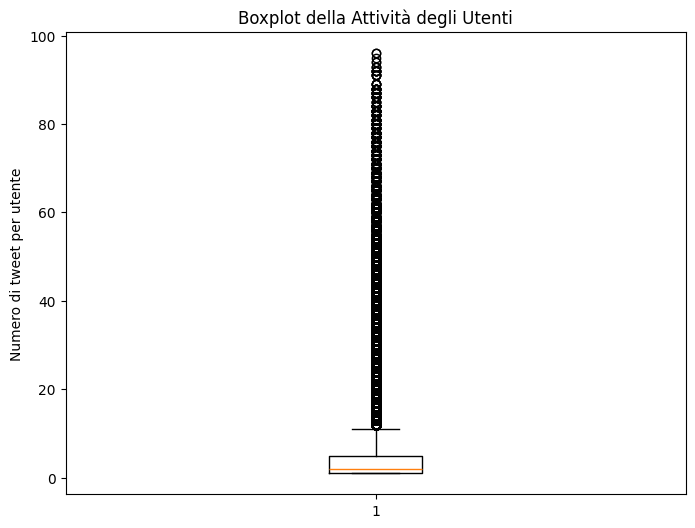

In [33]:
user_activity = wordle['UserID'].value_counts()

plt.figure(figsize=(8, 6))
plt.boxplot(user_activity)
plt.title('Boxplot della Attività degli Utenti')
plt.ylabel('Numero di tweet per utente')
plt.show()

Ricaviamoci con precisione i valori di media, varianza, moda e mediana. 

In [34]:
print("Mean: ", user_activity.mean())
print("Variance: ", user_activity.var())
print("Mode: ", user_activity.mode())
print("Median: ", user_activity.median())

Mean:  4.928695301372862
Variance:  68.99858824541084
Mode:  0    1
Name: count, dtype: int64
Median:  2.0


In [35]:
print(user_activity)

UserID
2.778092e+09    96
5.185310e+08    96
7.569270e+17    95
1.963916e+08    94
1.424114e+18    94
                ..
1.265912e+18     1
8.513366e+17     1
1.462236e+08     1
1.492807e+18     1
7.109468e+17     1
Name: count, Length: 406523, dtype: int64


Contando i valori unici di WordleID siamo in grado di risalire al numero complessivo di parole del giorno presenti nel nostro dataset.

In [36]:
unique_wordle_ids = wordle['WordleID'].nunique()
print("Number of unique WordleIDs:", unique_wordle_ids)

Number of unique WordleIDs: 107


Nel nostro dataset sono presenti 107 parole da indovinare. Il fatto che il numero massimo di partite condivise da un utente sia 96, ossia un valore inferiore a 107 dimostra che i nostri dati sono coerenti.

Usiamo la seguente quantizzazione per il numero di condivisioni di ciascun utente:
1. Low Activity = [1, 2];
2. Medium Activity = [3, 7];
3. High Activity = [8, 49];
4. Very High Activity = [50, 107];

In [37]:
bins = [0, 3, 8, 50, 107]
labels = ['Low Activity', 'Medium Activity', 'High Activity', 'Very High Activity']

user_macrocategories = pd.cut(user_activity, bins=bins, labels=labels)

wordle = wordle.merge(user_macrocategories.rename('UserActivity'), left_on='UserID', right_index=True)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,UserActivity
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True,Low Activity
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True,High Activity
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True,Low Activity
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]",True,Low Activity
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",True,Low Activity


Definiamo un'altra quantizzazione in base al periodo della giornata in cui è stato fatto il tweet:
1. Morning = [5, 12];
2. Afternoon = [12, 19];
3. Evening = [19, 24];
4. Night = [0, 5].

In [38]:
wordle['Created_At'] = pd.to_datetime(wordle['Created_At'])

bins = [0, 5, 12, 19, 24]
labels = ['Night','Morning','Afternoon','Evening']

wordle['TimeOfDay'] = pd.cut(wordle['Created_At'].dt.hour, bins=bins, labels=labels, right=False)

n = 5
wordle.sample(n).sort_values(by='TimeOfDay').head(n)

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,UserActivity,TimeOfDay
791149,293,1512495383670231042,2022-04-08 18:19:34+00:00,Twitter for iPhone,9.316165e+17,3,False,"[🟩🟩🟩🟩⬜, 🟩🟩🟩🟩⬜, 🟩🟩🟩🟩🟩]",True,High Activity,Afternoon
1239482,316,1520769646646935553,2022-05-01 14:18:32+00:00,Twitter Web App,5.924038e+08,4,False,"[⬜⬜⬜⬜⬜, ⬜🟨🟨⬜⬜, ⬜🟩🟩⬜⬜, 🟩🟩🟩🟩🟩]",True,Very High Activity,Afternoon
2010864,369,1539976513121951745,2022-06-23 14:19:46+00:00,Twitter for Android,1.072895e+09,4,False,"[⬛⬛⬛⬛🟨, ⬛🟩⬛⬛⬛, ⬛⬛⬛🟨⬛, 🟩🟩🟩🟩🟩]",True,Very High Activity,Afternoon
1240360,317,1521275863899197441,2022-05-02 23:50:04+00:00,Twitter Web App,9.065284e+07,2,False,"[🟩🟩⬜🟩⬜, 🟩🟩🟩🟩🟩]",True,High Activity,Evening
1385830,325,1524102513275904001,2022-05-10 19:02:10+00:00,Twitter Web App,1.115048e+18,5,False,"[⬛⬛⬛🟨⬛, ⬛🟩⬛⬛⬛, ⬛🟩⬛⬛⬛, ⬛🟩⬛⬛⬛, 🟩🟩🟩🟩🟩]",True,High Activity,Evening


Desideriamo conoscere in quali fasce orarie gli utenti sono più attivi. Visualizziamo questa informazione con un bar plot.

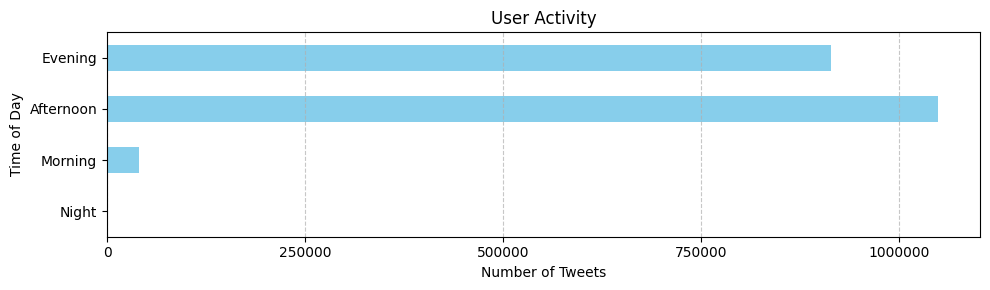

In [39]:
activity_by_time = wordle['TimeOfDay'].value_counts()

activity_by_time = activity_by_time.reindex(labels)

plt.figure(figsize=(10, 3))
activity_by_time.plot(kind='barh', color='skyblue')

# Set tick positions and labels for x-axis
tick_positions = [0, 250000, 500000, 750000, 1000000]
tick_labels = [str(val) for val in tick_positions]

plt.xticks(tick_positions, tick_labels)

plt.title('User Activity')
plt.ylabel('Time of Day')
plt.xlabel('Number of Tweets')

plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

La nuova parola del giorno viene rilasciata a mezzanotte della propria ora locale, nel nostro dataset però nessun utente ha condiviso la propria partita nella fascia oraria notturna.

Per assegnare a ciascuna parola un livello di difficoltà:
- Nel caso in cui il numero di sconfitte per quella parola sia maggiore di 2.2 volte il valore medio del numero di sconfitte, la parola è '__Very Hard__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 1 e 4.0 e la partita è vinta, la parola è '__Easy__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 4.0 e 4.5 e la partita è vinta, la parola è '__Medium__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 4.5 e 6 e la partita è vinta, la parola è '__Hard__'

In [40]:
mean_attempts = wordle[wordle['Win']].groupby('WordleID')['Attempts'].mean()

# Categorize WordleIDs based on the criteria
def categorize_difficulty(mean_attempt):
    if mean_attempt >= 4.5:
        return 'Hard'
    elif mean_attempt >= 4.0:
        return 'Medium'
    else:
        return 'Easy'

# Apply the categorization function to each WordleID
wordle['Difficulty'] = wordle['WordleID'].map(mean_attempts).apply(categorize_difficulty)

# Calculate the overall ratio of lost games to total games in the entire DataFrame
overall_lost_games_ratio = wordle[~wordle['Win']].shape[0] / wordle.shape[0]

# Define a function to check if the condition is met for a specific WordleID
def should_update_difficulty(wordle_id):
    wordle_subset = wordle[wordle['WordleID'] == wordle_id]
    lost_games_ratio = wordle_subset[~wordle_subset['Win']].shape[0] / wordle_subset.shape[0]
    return lost_games_ratio > 2.2*overall_lost_games_ratio

# Iterate over each unique WordleID
for unique_id in wordle['WordleID'].unique():
    # Check if the condition is met for the current WordleID
    if should_update_difficulty(unique_id):
        # Update the 'Difficulty' column for rows with the current WordleID
        wordle.loc[wordle['WordleID'] == unique_id, 'Difficulty'] = 'Very Hard'

In [41]:
num_very_hard = (wordle['Difficulty'] == 'Very Hard').sum()

# Print the number of rows
print("Number of rows with Difficulty 'Very Hard':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Hard').sum()
print("Number of rows with Difficulty 'Hard':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Medium').sum()
print("Number of rows with Difficulty 'Medium':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Easy').sum()
print("Number of rows with Difficulty 'Easy':", num_very_hard)

Number of rows with Difficulty 'Very Hard': 182957
Number of rows with Difficulty 'Hard': 167879
Number of rows with Difficulty 'Medium': 824939
Number of rows with Difficulty 'Easy': 827853


Verifichiamo di non aver introdotto per errore valori nulli in questa fase.

In [42]:
print(wordle.isnull().sum())

WordleID        0
ID              0
Created_At      0
Source          0
UserID          0
Attempts        0
Hard Mode       0
Match           0
Win             0
UserActivity    0
TimeOfDay       0
Difficulty      0
dtype: int64


Tracciamo un grafico a torta per vedere la distribuzione delle parole in base alla difficoltà

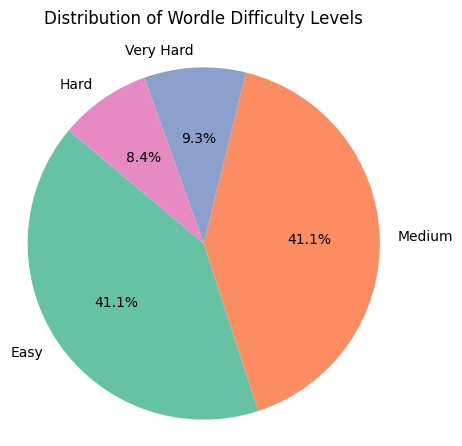

In [43]:
wordle_difficulty = wordle.groupby('WordleID')['Difficulty'].first().reset_index()
difficulty_counts = wordle_difficulty['Difficulty'].value_counts()

colors = plt.cm.Set2.colors

plt.figure(figsize=(5, 5))
plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', startangle=140, colors = colors)
plt.title('Distribution of Wordle Difficulty Levels', pad=20)
plt.axis('equal')  
plt.show()


Un'altra informazione che può risultare utile da visualizzare è da quale dispositivo vengono fatti i tweet.
Andiamo a visualizzare intanto i valori unici che assume la colonna 'Source' 

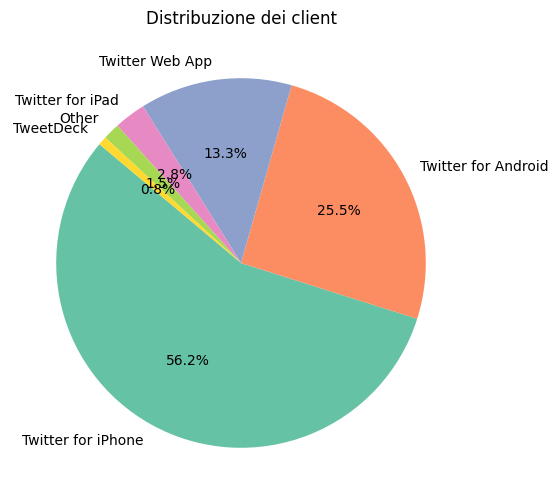

In [44]:
valori_client = wordle['Source'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(valori_client, labels=valori_client.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribuzione dei client')
plt.ylabel('')
plt.show()

Si può vedere che il client più utilizzato è l'app di Twitter per iPhone, quindi gli iPhone users sono quelli che nella popolazione twittano di più. 

### OLAP

Ora che è terminata la preparazione dei dati, procediamo con la analisi OLAP.

In [45]:
quantize_user_activity = ['Low Activity', 'Medium Activity', 'High Activity', 'Very High Activity']
quantize_time_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']
quantize_difficulty = ['Easy', 'Medium', 'Hard', 'Very Hard']

OLAP = np.zeros((len(quantize_user_activity),len(quantize_time_of_day),len(quantize_difficulty)))
for z in range(len(quantize_user_activity)):
    for j in range(len(quantize_time_of_day)):
        for i in range(len(quantize_difficulty)):
            # Filter dataframe
            filtered_data = wordle[(wordle['UserActivity'] == quantize_user_activity[z]) &
                                   (wordle['TimeOfDay'] == quantize_time_of_day[j]) &
                                   (wordle['Difficulty'] == quantize_difficulty[i])]
            # Calculate number of wins
            wins = filtered_data['Win'].sum()
            
            # Calculate number of matches
            matches = len(filtered_data)
            
            # Compute ratio of wins to matches (avoid division by zero)
            ratio = wins / matches * 100 if matches > 0 else np.nan
            
            # Populate OLAP cube
            OLAP[z, j, i] = ratio
OLAP

array([[[ 98.80418535,  98.25673534,          nan,  90.98497496],
        [ 98.50791395,  97.49666597,  93.86846457,  81.53318791],
        [ 98.62552473,  97.53104417,  95.23254685,  81.48188743],
        [         nan,          nan,          nan,          nan]],

       [[ 99.13232104,  98.25394135,          nan,  94.27580225],
        [ 98.90874998,  97.90839328,  95.49801952,  89.95271178],
        [ 98.9099637 ,  97.86641025,  96.38739431,  91.04007815],
        [         nan,          nan,          nan,          nan]],

       [[ 99.44618793,  98.90401672,          nan,  95.50115779],
        [ 99.20602515,  98.50027315,  96.70273328,  89.83644025],
        [ 99.09471977,  98.3891017 ,  96.87621207,  90.20856992],
        [         nan,          nan,          nan,          nan]],

       [[ 98.27586207,  98.48484848,          nan, 100.        ],
        [ 99.23509087,  98.54642331,  97.20637185,  87.93445879],
        [ 99.31563511,  98.49756098,  97.30397663,  88.5583524 ],
    

Facciamo uno slicing rispetto a TimeOfDay. Poichè la sera e il pomeriggio sono le fasce orarie di picco le prediligiamo. 

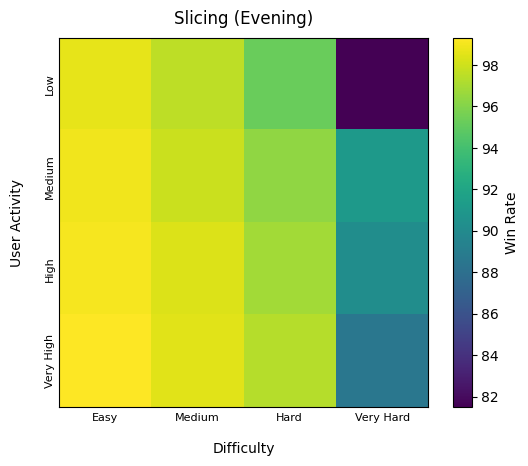

In [46]:
plt.imshow(OLAP[:, 2, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=25)
plt.title('Slicing (Evening)', pad=10)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show() 

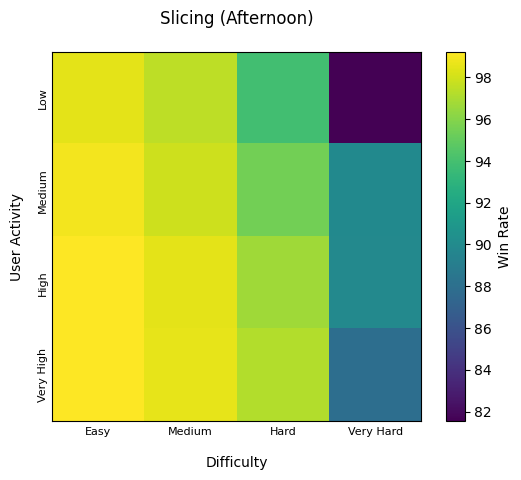

In [47]:
plt.imshow(OLAP[:, 1, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=20)
plt.title('Slicing (Afternoon)', pad=20)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show()

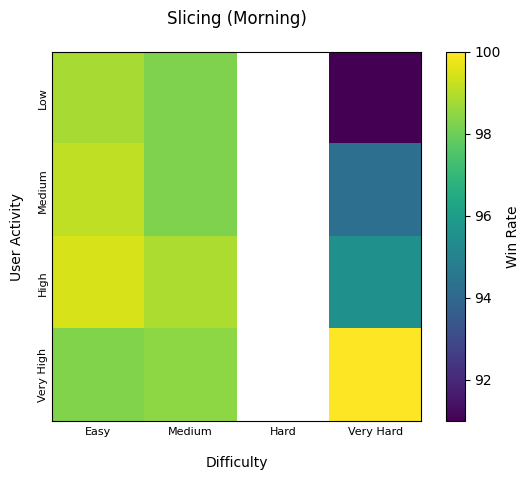

In [48]:
plt.imshow(OLAP[:, 0, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=20)
plt.title('Slicing (Morning)', pad=20)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show()

Possiamo notare come, in tutte le visualizzazioni sopra, il tasso di vittoria degli utenti medio attivi, attivi e molto attivi sia generalmente maggiore del tasso di vittoria del utenti poco attivi, in particolare in caso di parole molto difficili.

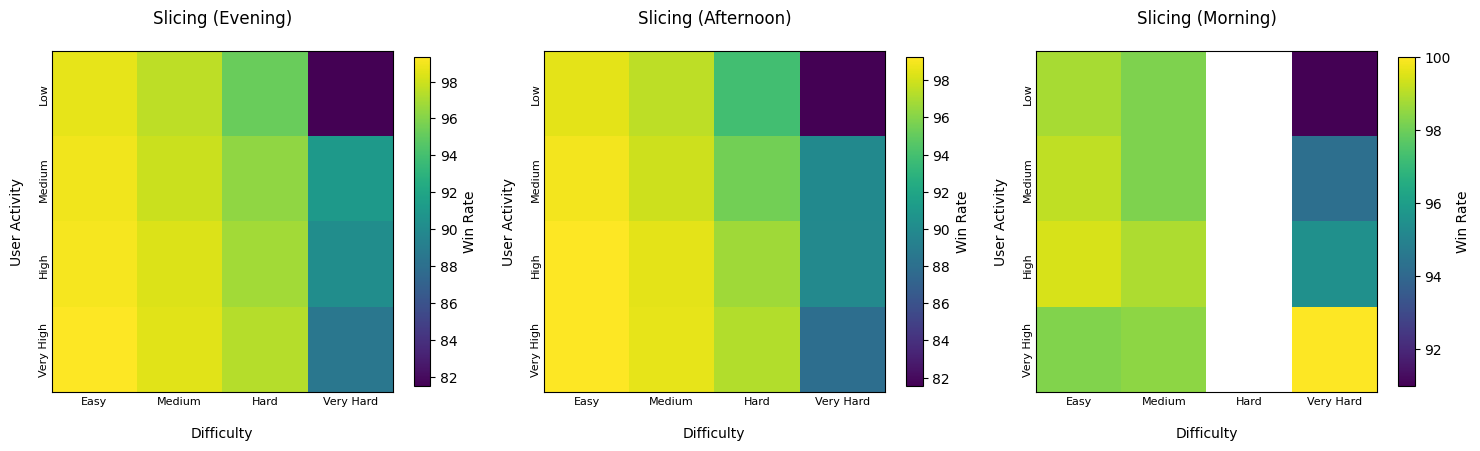

In [49]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot first image
im1 = axs[0].imshow(OLAP[:, 2, :])
for i, label in enumerate(quantize_difficulty):
    axs[0].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[0].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[0].set_xlabel('Difficulty', labelpad=25)
axs[0].set_ylabel('User Activity', labelpad=20)
axs[0].set_title('Slicing (Evening)', pad=20)
fig.colorbar(im1, ax=axs[0], label='Win Rate', shrink=0.7)
axs[0].set_yticks([])
axs[0].set_xticks([])

# Plot second image
im2 = axs[1].imshow(OLAP[:, 1, :])
for i, label in enumerate(quantize_difficulty):
    axs[1].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[1].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[1].set_xlabel('Difficulty', labelpad=25)
axs[1].set_ylabel('User Activity', labelpad=20)
axs[1].set_title('Slicing (Afternoon)', pad=20)
fig.colorbar(im2, ax=axs[1], label='Win Rate', shrink=0.7)
axs[1].set_yticks([])
axs[1].set_xticks([])

# Plot third image
im3 = axs[2].imshow(OLAP[:, 0, :])
for i, label in enumerate(quantize_difficulty):
    axs[2].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[2].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[2].set_xlabel('Difficulty', labelpad=25)
axs[2].set_ylabel('User Activity', labelpad=20)
axs[2].set_title('Slicing (Morning)', pad=20)
fig.colorbar(im3, ax=axs[2], label='Win Rate', shrink=0.7)
axs[2].set_yticks([])
axs[2].set_xticks([])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Facendo dicing verifichiamo la decrescita del tasso di vincinta per gli utenti poco attivi (_Low Activity_) e gli utenti molto attivi (_Very High Activity_) consideando come fascia oraria la sera.

In [50]:
print(OLAP[0, 2, :])
print(OLAP[3, 2, :])

[98.62552473 97.53104417 95.23254685 81.48188743]
[99.31563511 98.49756098 97.30397663 88.5583524 ]


Possiamo notare come la decrescita del tasso di vincita sia più attenuata nel caso di utenti molto attivi e come il divario nel tasso di vincinta aumenti all'aumentare della difficoltà delle parole. Visualizziamo questa informazone con un grafico a linea.

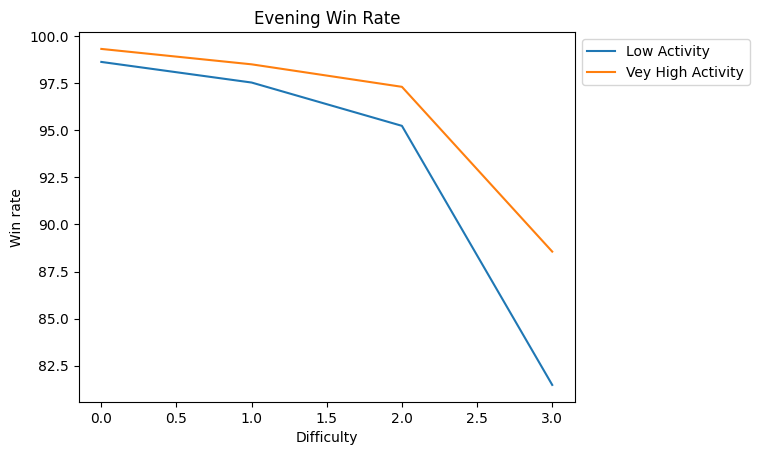

In [51]:
plt.xlabel('Difficulty')
plt.ylabel('Win rate')
plt.title('Evening Win Rate')
plt.plot(OLAP[0, 2, :], label='Low Activity') 
plt.plot(OLAP[3, 2, :], label='Vey High Activity') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.show() 

## Test statistici

### Test 1

Utilizziamo un T-test.

Ipotesi nulla: gli utenti poco attivi in caso di vittoria si comportano allo stesso modo degli utenti attivi/molto attivi in termini di numero medio di tentativi.

Ipotesi alternativa: gli utenti poco attivi in caso di vittoria non si comportano allo stesso modo degli utenti attivi/molto attivi in termini di numero medio di tentativi.

Prendiamo come livello di significatività 0.05. Sussiste una differenza statisticamente significativa?

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.


Stampiamo il numero di elementi per le due classi. 

In [52]:
total_population = len(wordle)
print(total_population)

winning_attempts_low_activity = wordle.loc[(wordle['UserActivity'] == 'Low Activity') & (wordle['Win'] == 1), 'Attempts']
winning_attempts_high_activity = wordle.loc[(wordle['UserActivity'] == 'High Activity') & (wordle['Win'] == 1), 'Attempts']
print(len(winning_attempts_low_activity))
print(len(winning_attempts_high_activity))
print(len(winning_attempts_high_activity)+len(winning_attempts_low_activity))

test_winning_attempts_low_activity = winning_attempts_low_activity.sample(n=30000)
test_winning_attempts_high_activity = winning_attempts_high_activity.sample(n=30000)

if len(test_winning_attempts_low_activity) >= 30 and len(test_winning_attempts_high_activity) >= 30:
    print("Sample size condition (n ≥ 30) is met for both groups.")
else:
    print("Sample size condition (n ≥ 30) is not met for both groups.")

if total_population >= 10 * (len(test_winning_attempts_low_activity)) and total_population >= 10 *(len(test_winning_attempts_high_activity)):
    print("Population size condition (N ≥ 10n) is met for both groups.")
else:
    print("Population size condition (N ≥ 10n) is not met for both groups.")

2003628
385692
1032598
1418290
Sample size condition (n ≥ 30) is met for both groups.
Population size condition (N ≥ 10n) is met for both groups.


La prima condizione è soddisfatta, la seconda???

In [53]:
#t_value, p_value = stats.ttest_ind(winning_attempts_low_activity, winning_attempts_high_activity)
t_value, p_value = stats.ttest_ind(test_winning_attempts_low_activity, test_winning_attempts_high_activity)

print("p-value:", p_value)

p-value: 1.5045753939599996e-257


Essendo il p-value minore del livello di significatività, possiamo rigettare l'ipotesi nulla. Possiamo concludere che l'andamento di una partita in caso di vittoria per gli utenti poco attivi NON è lo stesso andamento di una partita in caso di vittoria per gli utenti attivi.

In [54]:
t_value, p_value = stats.ttest_ind(test_winning_attempts_low_activity, test_winning_attempts_high_activity, alternative='greater')

print("p-value:", p_value)

p-value: 1.0


Essendo il p-value maggiore del livello di significatività, non possiamo rigettare l'ipotesi nulla. L'ipotesi nulla è che la media dei tentativi in caso di vittoria degli utenti poco attivi è maggiore della media dei tentativi in caso di vittoria degli utenti attivi. 

In [55]:
t_value, p_value = stats.ttest_ind(test_winning_attempts_low_activity, test_winning_attempts_high_activity, alternative='less')

print("p-value:", p_value)

p-value: 7.522876969799998e-258


Essendo il p-value minore del livello di significatività, possiamo rigettare l'ipotesi nulla. Possiamo concludere che la media dei tentativi in caso di vittoria per gli utenti poco attivi NON è minore della media dei tentativi in caso di vittoria per gli utenti attivi.

### Test 2


Siccome circa la metà dei tweet provengono dal Client di iPhone, proviamo a impostare un T-Test con le seguente ipotesi
- $H_0$ = gli utenti che twittano da iPhone hanno la stesso media dei tentativi rispetto all'intera popolazione
- $H_a$ = gli utenti che twittano da iPhone hanno una media di tentativi diversa da quella generale

In [56]:
iphone_users_attempts = wordle.loc[(wordle['Source'] == 'Twitter for iPhone'), 'Attempts']
other_users_attempts = other_users_attempts = wordle.loc[wordle['Source'] != 'Twitter for iPhone', 'Attempts']
print(len(iphone_users_attempts))
print(len(other_users_attempts))

# Esegui il test t-student per un campione
statistica_t, valore_p = stats.ttest_ind(iphone_users_attempts, other_users_attempts)

# Stampa i risultati del test
print("Statistiche t:", statistica_t)
print("Valore p:", valore_p)

1126618
877010
Statistiche t: -25.258827861871413
Valore p: 9.532579257057782e-141


## Metodi Predittivi

A partire dal DataFrame _wordle_ creiamo un DataFrame _user_stats_ dove ogni riga conterrà le informazioni relative a un singolo utente.

In [57]:
num_tweets_by_user = wordle.groupby('UserID')['ID'].count().reset_index()
num_tweets_by_user.columns = ['UserID', 'Num_tweets']

user_wins = wordle[wordle['Win'] == True].groupby('UserID').size().reset_index(name='User_Wins')

user_stats = pd.merge(num_tweets_by_user, user_wins, on='UserID', how='left')

user_stats['User_Wins'] = user_stats['User_Wins'].fillna(0)

total_attempts_by_user = wordle.groupby('UserID')['Attempts'].sum().reset_index()
total_attempts_by_user.columns = ['UserID', 'Total_Attempts']

user_stats = pd.merge(user_stats, total_attempts_by_user, on='UserID')

user_stats['User_Win_Rate'] = (user_stats['User_Wins'] / user_stats['Num_tweets'])*100

hard_mode_count_by_user = wordle.groupby('UserID')['Hard Mode'].sum().rename('Hard_Mode_Count')

user_stats = user_stats.set_index('UserID').join(hard_mode_count_by_user, how='left').reset_index()

user_stats['Hard_Mode_Count'] = user_stats['Hard_Mode_Count'].fillna(0)

wordle_wins = wordle[wordle['Win']]

user_attempts_counts = wordle_wins.groupby(['UserID', 'Attempts']).size().reset_index(name='Attempts_Count')

user_attempts_pivot = user_attempts_counts.pivot(index='UserID', columns='Attempts', values='Attempts_Count').reset_index()

user_attempts_pivot.columns = ['UserID', '1_attempts_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']

user_stats = pd.merge(user_stats, user_attempts_pivot, on='UserID', how='left')

user_stats = user_stats.fillna(0)

columns_to_convert = ['1_attempts_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']

for col in columns_to_convert:
    user_stats[col] = user_stats[col].astype(int)

user_stats = pd.merge(user_stats, wordle[['UserID','UserActivity']].drop_duplicates(), on='UserID', how='left')



In [58]:
user_stats.head()

,UserID,Num_tweets,User_Wins,Total_Attempts,User_Win_Rate,Hard_Mode_Count,1_attempts_Win,2_attempts_Win,3_attempts_Win,4_attempts_Win,5_attempts_Win,6_attempts_Win,UserActivity
0,187.0,1,1.0,2,100.0,0,0,1,0,0,0,0,Low Activity
1,422.0,1,1.0,4,100.0,1,0,0,0,1,0,0,Low Activity
2,521.0,3,3.0,16,100.0,0,0,0,0,1,0,2,Low Activity
3,556.0,5,5.0,19,100.0,0,0,0,2,2,1,0,Medium Activity
4,765.0,18,18.0,75,100.0,0,0,0,5,8,2,3,High Activity


Verifichiamo che non contenga valori nulli.

In [59]:
user_stats.isnull().sum()

UserID             0
Num_tweets         0
User_Wins          0
Total_Attempts     0
User_Win_Rate      0
Hard_Mode_Count    0
1_attempts_Win     0
2_attempts_Win     0
3_attempts_Win     0
4_attempts_Win     0
5_attempts_Win     0
6_attempts_Win     0
UserActivity       0
dtype: int64

A partire dal DataFrame _wordle_ creiamo un DataFrame _wordle_summary_ dove ogni riga conterrà le informazioni relative a una singola parola.

In [60]:
games_by_wordle = wordle.groupby('WordleID')['ID'].count().reset_index()
games_by_wordle.columns = ['WordleID', 'Number_of_Games']

wins_by_wordle = wordle[wordle['Win'] == True].groupby('WordleID')['Win'].count().reset_index()
wins_by_wordle.columns = ['WordleID', 'Number_of_Wins']

wordle_summary = pd.merge(games_by_wordle, wins_by_wordle, on='WordleID', how='left').fillna(0)

winning_attempts = wordle[wordle['Win'] == True]

mean_attempts_by_wordleid = winning_attempts.groupby('WordleID')['Attempts'].mean().reset_index()

wordle_summary = wordle_summary.merge(mean_attempts_by_wordleid, on='WordleID', how='left')

wordle_summary.rename(columns={'Attempts': 'Mean_Attempts_Victory'}, inplace=True)

wordle_summary['Win_Rate'] = (wordle_summary['Number_of_Wins'] / wordle_summary['Number_of_Games'])*100

hard_mode_counts = wordle[wordle['Hard Mode']].groupby('WordleID').size().reset_index(name='Hard_Mode_Count')

wordle_summary = pd.merge(wordle_summary, hard_mode_counts, on='WordleID', how='left')

wordle_summary['Hard_Mode_Count'] = wordle_summary['Hard_Mode_Count'].fillna(0)

wordle_win = wordle[wordle['Win']]

attempts_counts = wordle_win.groupby(['WordleID', 'Attempts']).size().unstack(fill_value=0)

attempts_counts.columns = ['1_attempt_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']

wordle_summary = pd.merge(wordle_summary, attempts_counts, on='WordleID', how='left')

attempts_counts = wordle.groupby(['WordleID', 'Attempts']).size().unstack(fill_value=0)

attempts_counts.columns = ['1_attempt', '2_attempts', '3_attempts', '4_attempts', '5_attempts', '6_attempts']

wordle_summary = pd.merge(wordle_summary, attempts_counts, on='WordleID', how='left')

wordle_summary = wordle_summary.fillna(0)

In [61]:
wordle_summary.head()

,WordleID,Number_of_Games,Number_of_Wins,Mean_Attempts_Victory,Win_Rate,Hard_Mode_Count,1_attempt_Win,2_attempts_Win,3_attempts_Win,4_attempts_Win,5_attempts_Win,6_attempts_Win,1_attempt,2_attempts,3_attempts,4_attempts,5_attempts,6_attempts
0,254,18694,18551,3.746698,99.235049,552,353,1795,5637,6331,3283,1152,353,1795,5637,6332,3283,1294
1,255,18592,18215,4.304200,97.972246,614,186,559,3275,6288,5322,2585,187,559,3275,6288,5322,2961
2,256,18797,18415,3.919033,97.967761,555,331,1727,5064,5377,3812,2104,332,1727,5064,5378,3812,2484
3,257,18866,18691,3.851158,99.072405,649,185,1665,5536,6202,3567,1536,185,1665,5536,6202,3569,1709
4,258,18691,18376,4.193187,98.314697,701,226,912,3629,6273,4991,2345,228,912,3629,6274,4992,2656


Verifichiamo che non contenga valori nulli.

In [62]:
wordle_summary.isnull().sum()

WordleID                 0
Number_of_Games          0
Number_of_Wins           0
Mean_Attempts_Victory    0
Win_Rate                 0
Hard_Mode_Count          0
1_attempt_Win            0
2_attempts_Win           0
3_attempts_Win           0
4_attempts_Win           0
5_attempts_Win           0
6_attempts_Win           0
1_attempt                0
2_attempts               0
3_attempts               0
4_attempts               0
5_attempts               0
6_attempts               0
dtype: int64

Verifichiamo che ci sia coerenza tra _wordle_,_user_stats_ e _wordle_summary_.

In [63]:
total_hard_mode_wordle_summary = wordle_summary['Hard_Mode_Count'].sum()
total_hard_mode_user_stats = user_stats['Hard_Mode_Count'].sum()
total_win_user_stats = user_stats['User_Wins'].sum()
total_win = wordle['Win'].sum()
total_hard_mode_count = hard_mode_count_by_user.sum()

print("Total Hard Mode Count in user_stats:", total_hard_mode_user_stats)
print("Total Hard Mode Count in wordle_summary:", total_hard_mode_wordle_summary)
print("Total Hard Mode Count:", total_hard_mode_count)
print("Total Win Count in user_stats:", total_win_user_stats)
print("Total Win Count in wordle:", total_win)
print("Number of users:", user_stats.shape[0])
print("Wordle number of users:", wordle['UserID'].nunique())

Total Hard Mode Count in user_stats: 120660
Total Hard Mode Count in wordle_summary: 120660
Total Hard Mode Count: 120660
Total Win Count in user_stats: 1952040.0
Total Win Count in wordle: 1952040
Number of users: 406523
Wordle number of users: 406523


Supponiamo di voler stimare una funzione che preveda il numero di condivisioni vincenti di un utente a partire dal suo numero complessivo di condivisioni. Prima di tutto possiamo utilizzare una rappresentazione grafica per verificare se le due features siano correlate, e se sia quindi possibile utilizzare una di queste features per predire l'altra.

Implementiamo le funzioni per il calcolo dell'MSE, dell'MAE e del RMSE: ci serviranno per valutare se il modello ottenuto è accettabile o meno.

In [64]:
# sommatoria del quadrato della differenza tra y vera e y predetta diviso il numero di y -> MSE
def MSE (y_pred,y_true):
   return 1/y_pred.shape[0] * np.abs((y_pred-y_true)).sum()

# sommatoria del valore assoluto della differenza tra y vera e y predetta diviso il numero di y -> MAE
def MAE (y_pred,y_true):
     return 1/y_pred.shape[0] * ((y_pred-y_true)**2).sum()

# radice della sommatoria del quadrato della differenza tra y vera e y predetta diviso il numero di y -> RMSE
def RMSE (y_pred,y_true):
     return np.sqrt(1/y_pred.shape[0] * ((y_pred-y_true)**2).sum())

Abbiamo visto che ci sono tre metriche per valutare i modelli a regressione di machine learning:

- lo scarto medio assoluto (MAE - Mean Absolute Error);
- l’errore quadratico medio (MSE - Mean Squared Error);
- la radice dell’errore quadratico medio (RMSE - Root of Mean Squared Error).

Per verificare che il risultato ottenuto sia un buon risultato ricorriamo al modello nullo. L'errore del modello nullo deve essere maggiore dell'errore del modello che abbiamo ottenuto per poter dire di aver ottenuto un modello accettabile.

### Codifica dei dati

In [65]:
wordle_clustering = wordle.copy()  # creo una copia del dataset per il clustering
wordle_clustering.sample(10).head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,UserActivity,TimeOfDay,Difficulty
1316089,320,1522227034147409920,2022-05-05 14:49:41+00:00,Twitter for iPhone,1.169691e+18,4,True,"[⬛⬛⬛⬛🟨, ⬛⬛⬛🟩🟩, 🟩🟩⬛🟩🟩, 🟩🟩🟩🟩🟩]",True,Low Activity,Afternoon,Very Hard
861567,298,1514375719194877953,2022-04-13 22:51:21+00:00,Twitter for Android,1.999593e+08,4,False,"[⬛⬛⬛⬛⬛, ⬛⬛⬛⬛⬛, 🟨🟨⬛⬛⬛, 🟩🟩🟩🟩🟩]",True,High Activity,Evening,Easy
495373,278,1507056317877346308,2022-03-24 18:06:40+00:00,Twitter for Android,1.461097e+18,4,False,"[🟩⬛⬛⬛🟩, 🟩🟩⬛⬛🟩, 🟩🟩🟩⬛🟨, 🟩🟩🟩🟩🟩]",True,High Activity,Afternoon,Easy
580429,283,1508592980982124544,2022-03-28 23:52:49+00:00,Twitter for Android,2.077428e+08,6,False,"[🟩🟩⬛⬛⬛, 🟩🟩⬛⬛⬛, 🟩🟩🟩⬛⬛, 🟩🟩🟩⬛⬛, 🟩🟩🟩⬛⬛, 🟩🟩🟩⬛🟩]",False,High Activity,Evening,Medium
194830,263,1501637658140762117,2022-03-09 19:14:51+00:00,Twitter for iPhone,1.310354e+08,3,False,"[🟨⬜⬜⬜🟨, ⬜🟩⬜⬜⬜, 🟩🟩🟩🟩🟩]",True,Very High Activity,Evening,Easy


La colonna match per il clustering può essere utilizzata estraendo la quantità di quadratini per i vari colori utilizzati in ogni match, dopo aver estratto l'informazione possiamo eliminare la colonna match

In [66]:

# Function to count occurrences of each type of square emoji
def count_squares(emojis):
    green = 0
    yellow = 0
    black = 0
    white = 0
    for emoji_list in emojis:
        green += emoji_list.count('🟩')
        yellow += emoji_list.count('🟨')
        black += emoji_list.count('⬛')
        white += emoji_list.count('⬜')
    black_white = black + white
    return green, yellow, black_white

# Apply the function to 'Match' column and create new columns
wordle_clustering['Green_Count'], wordle_clustering['Yellow_Count'], wordle_clustering['BlackWhite_Count'] = zip(*wordle_clustering['Match'].apply(count_squares))

wordle_clustering.drop(columns=['Match'], axis = 1, inplace=True) # rimuovo la colonna

wordle_clustering.sample(10).head(10)

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
951619,302,1515746610973753347,2022-04-17 17:38:47+00:00,Twitter for iPhone,1.457388e+18,4,False,True,Low Activity,Afternoon,Medium,12,2,6
946848,302,1515775952021860358,2022-04-17 19:35:23+00:00,Twitter for iPhone,9.558020e+07,4,False,True,High Activity,Evening,Medium,5,7,8
705552,289,1510752221260320769,2022-04-03 22:52:52+00:00,Twitter for iPhone,2.968248e+08,5,False,True,Medium Activity,Evening,Medium,17,1,7
2007111,369,1540006137298243584,2022-06-23 16:17:29+00:00,Twitter for Android,7.458516e+17,4,False,True,High Activity,Afternoon,Medium,12,0,8
428948,275,1506005266700984321,2022-03-21 20:30:10+00:00,Twitter for iPhone,1.188269e+18,5,False,True,Medium Activity,Evening,Easy,9,6,10
2043360,371,1540776970694311938,2022-06-25 19:20:30+00:00,Twitter for iPhone,1.457571e+18,4,False,True,High Activity,Evening,Medium,12,4,4
1799357,355,1534872169003589632,2022-06-09 12:16:56+00:00,Twitter for iPhone,4.713624e+08,5,False,True,High Activity,Afternoon,Medium,13,3,9
1452117,328,1525139450338193410,2022-05-13 15:42:35+00:00,Twitter for iPhone,6.818874e+07,5,False,True,High Activity,Afternoon,Easy,7,7,11
1614677,339,1529100168607547392,2022-05-24 14:01:04+00:00,Twitter for Android,1.218247e+08,6,False,True,Low Activity,Afternoon,Medium,6,9,15
458483,276,1506319544461238281,2022-03-22 17:19:00+00:00,Twitter for Android,1.045544e+09,2,False,True,Low Activity,Afternoon,Medium,5,3,2


Iniziamo a preparare il nostro dataset per il clustering, convertiamo le colonne HardMode e Win da Booleane a interi, 1 quando si ha True e 0 quando si ha false

In [67]:
wordle_clustering['Hard Mode'] = wordle_clustering['Hard Mode'].astype(int)
wordle_clustering['Win'] = wordle_clustering['Win'].astype(int)
wordle_clustering.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,0,1,Low Activity,Evening,Easy,6,4,5
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,0,1,High Activity,Evening,Easy,9,0,11
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,0,1,Low Activity,Evening,Easy,8,0,7
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,0,1,Low Activity,Evening,Easy,6,2,7
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,0,1,Low Activity,Evening,Easy,9,1,5


Ora iniziamo a convertire i valori qualitativi in valori quantitativi tramite una codifica ordinale, iniziamo da TimeOfDay, in ordine crescente in base al momento del giorno

In [68]:
ordinal_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
wordle_clustering['TimeOfDay'] = wordle_clustering['TimeOfDay'].map(ordinal_mapping)
wordle_clustering.head()


,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,0,1,Low Activity,3,Easy,6,4,5
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,0,1,High Activity,3,Easy,9,0,11
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,0,1,Low Activity,3,Easy,8,0,7
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,0,1,Low Activity,3,Easy,6,2,7
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,0,1,Low Activity,3,Easy,9,1,5


Analogamente si fa per Source, UserActivity, Difficulty

In [69]:
# UserActivity
ordinal_mapping = {'Low Activity': 1, 'Medium Activity': 2, 'High Activity': 3, 'Very High Activity': 4}
wordle_clustering['UserActivity'] = wordle_clustering['UserActivity'].map(ordinal_mapping)
# Source
ordinal_mapping = {'Twitter for iPhone' : 1, 'Twitter for Android' : 2, 'Twitter Web App' : 3, 'Twitter for iPad' : 4, 'Other' : 5, 'TweetDeck' : 6}
wordle_clustering['Source'] = wordle_clustering['Source'].map(ordinal_mapping)
# Difficulty
ordinal_mapping = {'Easy':1, 'Medium':2, 'Hard':3, 'Very Hard':4}
wordle_clustering['Difficulty'] = wordle_clustering['Difficulty'].map(ordinal_mapping)

wordle_clustering.head()



,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,1,3.681676e+07,3,0,1,1,3,1,6,4,5
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,1,4.825910e+08,4,0,1,3,3,1,9,0,11
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,1,1.397624e+18,3,0,1,1,3,1,8,0,7
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,1,1.255905e+18,3,0,1,1,3,1,6,2,7
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,1,2.528937e+08,3,0,1,1,3,1,9,1,5


Siccome Created_At non aggiunge ulteriori informazioni, dato che WordleID indica in un certo senso il giorno e l'orario è presente nella colonna TimeOfDay, quindi decidiamo di eliminare questa colonna

In [70]:
wordle_clustering.drop(columns=['Created_At', 'ID', 'UserID'], axis = 1, inplace=True) # rimuovo la colonna
wordle_clustering.head()


,WordleID,Source,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1,3,0,1,1,3,1,6,4,5
1,254,1,4,0,1,3,3,1,9,0,11
2,254,1,3,0,1,1,3,1,8,0,7
3,254,1,3,0,1,1,3,1,6,2,7
4,254,1,3,0,1,1,3,1,9,1,5


### Normalizzazione

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(wordle_clustering)

# visualizziamo la normalizzazione
X_scaled.view()

array([[0.        , 0.        , 0.4       , ..., 0.24      , 0.15384615,
        0.16666667],
       [0.        , 0.        , 0.6       , ..., 0.36      , 0.        ,
        0.36666667],
       [0.        , 0.        , 0.4       , ..., 0.32      , 0.        ,
        0.23333333],
       ...,
       [1.        , 0.        , 0.6       , ..., 0.28      , 0.19230769,
        0.26666667],
       [1.        , 0.4       , 0.2       , ..., 0.2       , 0.11538462,
        0.06666667],
       [1.        , 0.2       , 0.6       , ..., 0.44      , 0.03846154,
        0.26666667]])

### Regressione Lineare

#### User_stats

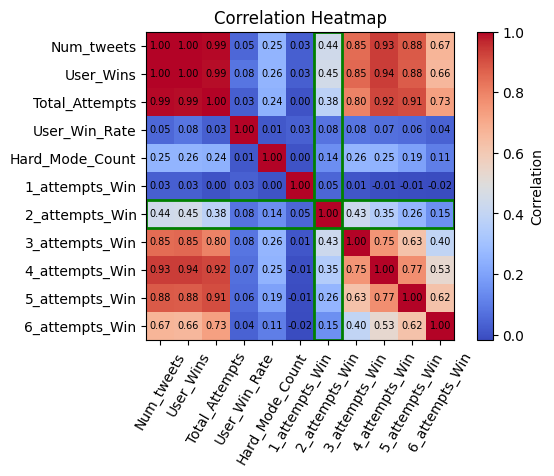

In [104]:
from matplotlib.patches import Rectangle

features = user_stats.drop(columns=['UserActivity', 'UserID'])
user_norm = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

r = user_norm.corr()

plt.figure(figsize=(6, 4))
plt.imshow(r, cmap='coolwarm', interpolation='nearest')

for i in range(len(r.columns)):
    for j in range(len(r.columns)):
        plt.text(j, i, "{:.2f}".format(r.iloc[i, j]), ha='center', va='center', color='black', fontsize=7)

highlight_row = r.index.get_loc('2_attempts_Win')
rect = Rectangle((-0.5, highlight_row - 0.5), len(r.columns), 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect)

highlight_col = r.columns.get_loc('2_attempts_Win')
col_rect = Rectangle((highlight_col - 0.5, -0.5), 1, len(r.columns), linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(col_rect)

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(len(r.columns)), r.columns, rotation=60)
plt.yticks(range(len(r.columns)), r.columns)
plt.show()

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Dividi il dataset in features (X) e variabile dipendente (y)
X = user_stats[['2_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']]
y = user_stats['3_attempts_Win']

X_scaled_regression = scaler.fit_transform(X)
# Dividi il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_regression, y, test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = model.predict(X_test)

In [106]:
mean_attempts = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_attempts

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE delmodello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.9212811280574862
MSE delmodello nullo:  1.2871028352641893


#### Wordle

In [107]:
wordle_clustering.head()

,WordleID,Source,Attempts,Hard Mode,Win,UserActivity,TimeOfDay,Difficulty,Green_Count,Yellow_Count,BlackWhite_Count
0,254,1,3,0,1,1,3,1,6,4,5
1,254,1,4,0,1,3,3,1,9,0,11
2,254,1,3,0,1,1,3,1,8,0,7
3,254,1,3,0,1,1,3,1,6,2,7
4,254,1,3,0,1,1,3,1,9,1,5


Ricorrendo a una heatmap cerchiamo di comprendere se ci sono caratteristiche che variano insieme. 

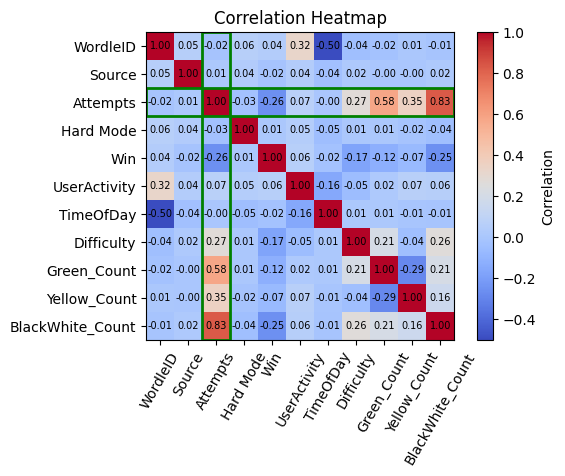

In [108]:
from matplotlib.patches import Rectangle

features = wordle_clustering[['WordleID', 'Source', 'Attempts', 'Hard Mode', 'Win', 'UserActivity', 'TimeOfDay', 'Difficulty', 'Green_Count', 'Yellow_Count', 'BlackWhite_Count']]
wordle_norm = pd.DataFrame(scaler.fit_transform(wordle_clustering), columns=features.columns)

r = wordle_norm.corr()

plt.figure(figsize=(6, 4))
plt.imshow(r, cmap='coolwarm', interpolation='nearest')

for i in range(len(r.columns)):
    for j in range(len(r.columns)):
        plt.text(j, i, "{:.2f}".format(r.iloc[i, j]), ha='center', va='center', color='black', fontsize=7)

highlight_row = r.index.get_loc('Attempts')
rect = Rectangle((-0.5, highlight_row - 0.5), len(r.columns), 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect)

highlight_col = r.columns.get_loc('Attempts')
col_rect = Rectangle((highlight_col - 0.5, -0.5), 1, len(r.columns), linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(col_rect)

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(len(r.columns)), r.columns, rotation=60)
plt.yticks(range(len(r.columns)), r.columns)
plt.show()

Va osservato che Green_Count, Yellow_Count e BlackWhite_Count non coincidono con il numero di lettere 'uniche', poichè per ciascuna categoria, un utente può aver inserire la stessa lettera più volte nello stesso tentativo o in più tentativi diversi (per esempio, al primo tentativo l'utente ha compreso che la A è la prima lettera, aumentando Green_Count di uno, al secondo tentativo può averla inserita nuovamente come prima lettera, aumentando Green_Count nuovamente di uno seppur la lettera sia la stessa).

E' allora interessante notare come l'informazione riguardante il numero di tentativi sia più facilmente ricavabile dal numero di lettere non presenti nella parola inserite dall'utente piuttosto che dal numero di lettere presenti nella parola inserite al posto sbagliato o dal numero di lettere presenti nella parola inserite nell'ordine corretto.

Si può inoltre sottolineare la debole correlazione negativa tra il numero di tentativi e di vittorie. Si può immaginare che pochi utenti si arrendando subito, ai primi tentativi, e va ricordato che la partita è persa al sesto tentativo senza successo. 

Con il nostro modello predittivo vogliamo prevedere il numero di tentativi di un tweet. Ci interessiamo allora solamente alla riga (o equivalentemente alla colonna) che interessa Attempts. 
Proviamo a basare la nostra predizione sulle caratteristiche che sono maggiormente correlate (positivamente o negativamente) con il numero di tentativi. In questo caso proviamo in un primo momento a predire il numero di tentivi di un tweet sapendo se il tweet è vincente o meno e la difficoltà della parola da indovinare. In un secondo momento aggiungiamo in input l'informazione relativa al numero di lettere non presenti nella parola del giorno che l'utente ha inserito e confrontiamo i risultati. 

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Dividi il dataset in features (X) e variabile dipendente (y)
X = wordle_clustering[['Win', 'Difficulty']]
y = wordle_clustering['Attempts']

X_scaled_regression = scaler.fit_transform(X)
# Dividi il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_regression, y, test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = model.predict(X_test)

mean_attempts = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_attempts

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE delmodello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.879364400732295
MSE delmodello nullo:  0.9393789755181636


Il nostro modello è lievemente più accurato del modello nullo. 

In [110]:
# Dividi il dataset in features (X) e variabile dipendente (y)
X = wordle_clustering[['Win', 'Difficulty', 'BlackWhite_Count']]
y = wordle_clustering['Attempts']

X_scaled_regression = scaler.fit_transform(X)
# Dividi il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_regression, y, test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = model.predict(X_test)

mean_attempts = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_attempts

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE delmodello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.5174696623081894
MSE delmodello nullo:  0.9393789755181636


Il nostro modello, grazie all'informazione aggiunta, è più accurato del modello nullo e del modello precedente.

#### Wordle_Summary

Supponiamo di voler stimare una funzione che preveda il twitter win rate della prossima parola del giorno a partire dal numero complessivo di condivisioni, sia vincenti che non, con 3 tentativi, 4 tentativi e 6 tentativi e il numero di condivisioni con la modalità difficile. 

In [111]:
wordle_summary.head()

,WordleID,Number_of_Games,Number_of_Wins,Mean_Attempts_Victory,Win_Rate,Hard_Mode_Count,1_attempt_Win,2_attempts_Win,3_attempts_Win,4_attempts_Win,5_attempts_Win,6_attempts_Win,1_attempt,2_attempts,3_attempts,4_attempts,5_attempts,6_attempts
0,254,18694,18551,3.746698,99.235049,552,353,1795,5637,6331,3283,1152,353,1795,5637,6332,3283,1294
1,255,18592,18215,4.304200,97.972246,614,186,559,3275,6288,5322,2585,187,559,3275,6288,5322,2961
2,256,18797,18415,3.919033,97.967761,555,331,1727,5064,5377,3812,2104,332,1727,5064,5378,3812,2484
3,257,18866,18691,3.851158,99.072405,649,185,1665,5536,6202,3567,1536,185,1665,5536,6202,3569,1709
4,258,18691,18376,4.193187,98.314697,701,226,912,3629,6273,4991,2345,228,912,3629,6274,4992,2656


Ricorriamo nuovamente a una heatmap per visualizzare le caratteristiche che variano insieme. 

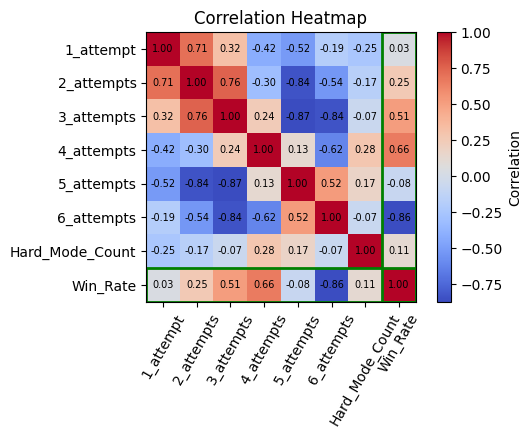

In [112]:
from matplotlib.patches import Rectangle

features = wordle_summary[['1_attempt', '2_attempts', '3_attempts','4_attempts' ,'5_attempts','6_attempts', 'Hard_Mode_Count', 'Win_Rate']]
wordle_norm = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

r = wordle_norm.corr()

plt.figure(figsize=(5.5, 3.5))
plt.imshow(r, cmap='coolwarm', interpolation='nearest')

for i in range(len(r.columns)):
    for j in range(len(r.columns)):
        plt.text(j, i, "{:.2f}".format(r.iloc[i, j]), ha='center', va='center', color='black', fontsize=7)

highlight_row = r.index.get_loc('Win_Rate')  # Get the index of 'Win_Rate'
rect = Rectangle((-0.5, highlight_row - 0.5), len(r.columns), 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect)

highlight_col = r.columns.get_loc('Win_Rate')  # Get the index of 'Win_Rate'
col_rect = Rectangle((highlight_col - 0.5, -0.5), 1, len(r.columns), linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(col_rect)

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(len(r.columns)), r.columns, rotation=60)
plt.yticks(range(len(r.columns)), r.columns)
plt.show()

E' interessante notare come:
- il win rate sia scorrelato dal numero di condivisioni con un tentativo o cinque tentativi
- vi sia una correlazione positiva debole con il numero di condivisioni con due tentativi e con la modalità difficile
- vi sia una correlazione positiva moderata con il numero di condivisioni con tre tentativi e quattro tentativi
- vi sia una forte correlazione negativa con il numero di condivisioni con 6 tentativi 

In [113]:
# Dividiamo il dataset in features (X) e variabile dipendente (y)
X = wordle_summary[['3_attempts','4_attempts','6_attempts', 'Hard_Mode_Count']]
y = wordle_summary['Win_Rate']

# Scaliamo
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)
y_scaled = y

# Dividiaimo il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

# Creaiamo un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestriamo il modello sui dati di addestramento
model.fit(X_train, y_train)

# Facciamo previsioni sui dati di test
y_pred = model.predict(X_test)

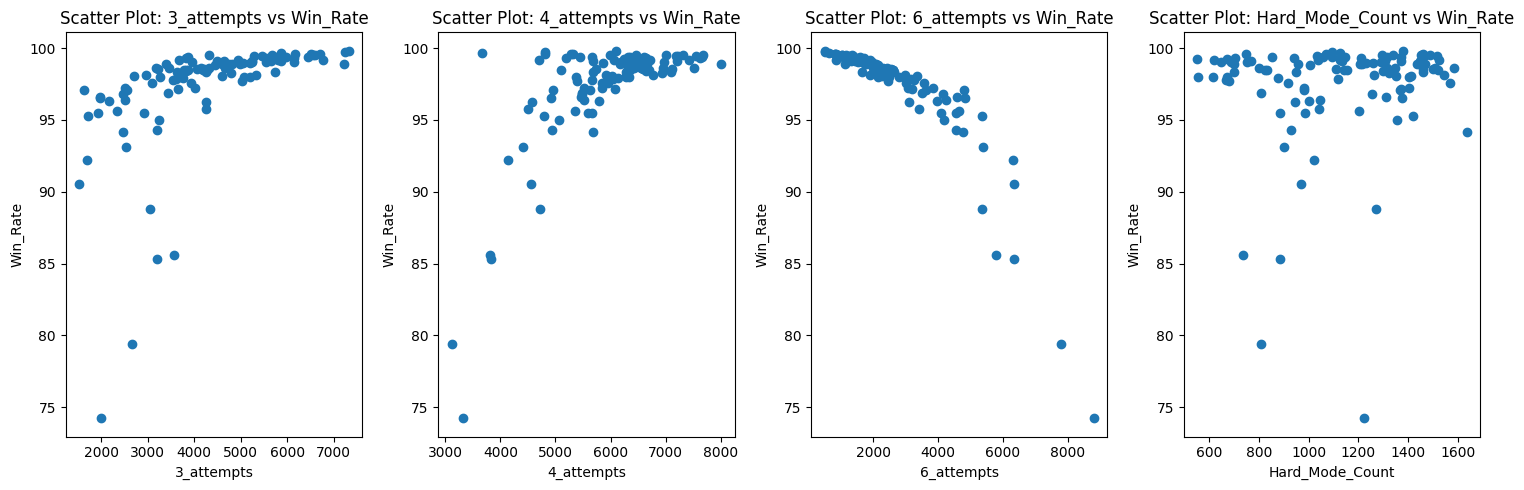

In [114]:
num_columns = X.shape[1]
plt.figure(figsize=(15, 5))

for i in range(num_columns):
    plt.subplot(1, num_columns, i+1)
    plt.scatter(X.iloc[:, i], y)
    plt.xlabel(X.columns[i])
    plt.ylabel('Win_Rate')
    plt.title(f'Scatter Plot: {X.columns[i]} vs Win_Rate')

plt.tight_layout()
plt.show()


Andiamo a confrontare il modello che abbiamo ottenuto con il modello nullo

In [115]:
mean_win_rate = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_win_rate

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE delmodello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.8029354250631555
MSE delmodello nullo:  2.9381860615887136


Anche in questo caso il nostro modello è più accurato del modello nullo.

### Regressione Logistica

In [ ]:
wordle_clustering.head()

Andiamo a vedere la regressione logistica basandoci sulla quantità di quadrati dei vari colori

In [ ]:
from sklearn.linear_model import LogisticRegression
#codice qui
y = wordle_clustering['Win']
x = wordle_clustering[['Green_Count','Yellow_Count','BlackWhite_Count','UserActivity','TimeOfDay','Hard Mode']]
x = scaler.fit_transform(x)

print(np.sum(y==1))
print(np.sum(y==0))
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)
reg = LogisticRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)
print(y_pred)
print(reg.score(x_valid, y_valid))

Confrontiamo con il modello nullo

In [ ]:
classe1 = np.sum(y_valid ==1)/x_valid.shape[0]
classe0 = np.sum(y_valid==0)/x_valid.shape[0]
print(classe0)
print(classe1)

In questo caso si nota che la regressione logistica performa meglio rispetto al modello nullo ma non in modo rilevante, questo lieve miglioramento è fornito dal contenuto informativo fornito dal numero di quadratini di vario colore

### Clustering con K-Means

Poichè la computazione dell'indice di silhouette per un dataset così corposo (circa 2 milioni di righe e 11 colonne) è onerosa, decidiamo di farci guidare nella scelta di un K ottimale dal metodo del gomito.

In [ ]:
from sklearn.cluster import KMeans

inertias = []

for i in range(1,20):
    print(i) #per sapere a che punto è con la computazione
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
print(inertias)


In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)

# Fit KMeans model to the data
kmeans.fit(X_scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

# Optionally, add cluster labels back to the dataframe
wordle_clustering['Cluster'] = cluster_labels


Seppur non sia distinguibile in maniera evidente un valore tale per cui si abbia 'un gomito', possiamo prendere un K a nostra scelta. 

***user_stats***

In [ ]:
user_clustering = user_stats.copy()

user_clustering.drop(columns='UserActivity',inplace=True)

# traduciamo in numeri la variabile categorica User Activity
# ordinal_mapping = {'Low Activity': 1, 'Medium Activity': 2, 'High Activity': 3, 'Very High Activity': 4}
# user_clustering['UserActivity'] = user_clustering['UserActivity'].map(ordinal_mapping)

user_clustering.head()

In [ ]:
scaler = MinMaxScaler()

X_scaled_user = scaler.fit_transform(user_clustering)

# visualizziamo la normalizzazione
X_scaled_user.view()

inertias_user = []

for i in range(1,16):
    print(i) #per sapere a che punto è con la computazione
    kmeans = KMeans(n_clusters=i, random_state=16)
    kmeans.fit(X_scaled_user)
    inertias_user.append(kmeans.inertia_)

plt.plot(range(1, 16), inertias_user, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Prendiamo K = 4.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=16)

# Fit KMeans model to the data
kmeans.fit(X_scaled_user)

# Get cluster labels
cluster_labels = kmeans.labels_

# Optionally, add cluster labels back to the dataframe
user_clustering['Cluster'] = cluster_labels

user_clustering.sample(5).head()

Realizziamo alcuni grafici per fare alcune osservazioni sulle caratteristiche che accomunano i dati all'interno di uno stesso cluster. 

In [ ]:
# Group win rate by cluster
clusters = user_clustering['Cluster'].unique()

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Plot box plots for each cluster
for i, cluster in enumerate(clusters):
    win_rates = user_clustering[user_clustering['Cluster'] == cluster]['User_Win_Rate']
    axs[i].boxplot(win_rates)
    axs[i].set_title(f'Cluster {cluster}')
    if i == 0:
        axs[i].set_ylabel('Win Rate')

plt.show()

**TODO:**
Possiamo notare innanzitutto come nei cluster 0, 2 e 3 siano raccolti gli utenti con win rate per la maggior parte alto, mentre nel cluster 3 sono raccolti gli utenti con win rate per la maggior parte basso. 

In [ ]:
# Group by cluster and sum the attempts columns
cluster_attempts = user_clustering.groupby('Cluster')[['1_attempts_Win', '2_attempts_Win', '3_attempts_Win', '4_attempts_Win', '5_attempts_Win', '6_attempts_Win']].sum()

for cluster in cluster_attempts.index:
    plt.figure(figsize=(6, 6))
    plt.bar(range(1, 7), cluster_attempts.loc[cluster])
    plt.title(f'Attempts Distribution for Cluster {cluster}')
    plt.xlabel('Number of Attempts')
    plt.ylabel('Frequency')
    plt.xticks(range(1, 7))
    plt.show()

**TODO**
Possiamo notare innanzitutto come nei cluster 0, 1 e 2 la distribuzione di vittorie per tentativi sia all'apparenza simile nell'andamento (con un picco in tentativi, 3 e 5 circa simili e a decrescere 6, 2 e 1), tuttavia il cluster 0 contiene più elementi del cluster 2 e il cluster 2 contiene più elementi del cluster 1. L'unico cluster differente è il cluster 3, il quale, oltre ad avere un numero estramemente basso di punti che lo caratterizzano (di 10^2), possiede una distribuzione di tentativi vincenti diversa, in ordine crescente da 1 a 6.

In [ ]:
print("Cluster 0 size:", user_clustering[user_clustering['Cluster'] == 0].shape[0])
print("Cluster 1 size:",user_clustering[user_clustering['Cluster'] == 1].shape[0])
print("Cluster 2 size:",user_clustering[user_clustering['Cluster'] == 2].shape[0])
print("Cluster 3 size:",user_clustering[user_clustering['Cluster'] == 3].shape[0])

In [ ]:
print(user_clustering[user_clustering['Cluster'] == 0]['Hard_Mode_Count'].sum()/user_clustering[user_clustering['Cluster'] == 0].shape[0])
print(user_clustering[user_clustering['Cluster'] == 1]['Hard_Mode_Count'].sum()/user_clustering[user_clustering['Cluster'] == 1].shape[0])
print(user_clustering[user_clustering['Cluster'] == 2]['Hard_Mode_Count'].sum()/user_clustering[user_clustering['Cluster'] == 2].shape[0])
print(user_clustering[user_clustering['Cluster'] == 3]['Hard_Mode_Count'].sum()/user_clustering[user_clustering['Cluster'] == 3].shape[0])

La frazione di partite eseguite in modalità difficile è maggiore nel cluster 0.

In linea con il nostro obiettivo analitico, andiamo a vedere il numero medio di tweet per i vari cluster